In [2]:
pip install fuzzywuzzy

In [3]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from fuzzywuzzy import fuzz
import networkx as nx
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import json
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Incearca sa importe sentence-transformers pentru embeddings semantice
try:
    from sentence_transformers import SentenceTransformer
    semantic_embeddings_available = True
except ImportError:
    semantic_embeddings_available = False
    print("Nota: Biblioteca sentence-transformers nu este instalata. Vom folosi o abordare alternativa pentru similaritatea semantica.")

In [6]:
# Incarcarea datelor
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/veridion_entity_resolution_challenge.snappy.parquet')
print(f"Datele initiale contin {len(df)} inregistrari si {len(df.columns)} coloane.")

Datele inițiale conțin 33446 înregistrări și 75 coloane.


In [7]:
# Selectarea atributelor relevante pentru deduplicare
key_columns = [
    'company_name',
    'website_domain',
    'primary_phone',
    'phone_numbers',
    'primary_email',
    'emails',
    'main_country_code',
    'main_city',
    'main_address_raw_text',
    'company_legal_names',
    'company_commercial_names',

    'naics_2022_primary_code',
    'main_business_category',
    'main_industry',
    'year_founded'
]


In [8]:
# Verificam existenta coloanelor in setul de date
available_columns = [col for col in key_columns if col in df.columns]
print(f"Coloane disponibile pentru deduplicare: {available_columns}")

Coloane disponibile pentru deduplicare: ['company_name', 'website_domain', 'primary_phone', 'phone_numbers', 'primary_email', 'emails', 'main_country_code', 'main_city', 'main_address_raw_text', 'company_legal_names', 'company_commercial_names', 'naics_2022_primary_code', 'main_business_category', 'main_industry', 'year_founded']


In [9]:
# Functie pentru preprocesarea textului
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Convertim la lowercase si eliminam caracterele speciale
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [10]:
# Curatarea si preprocesarea datelor
for col in available_columns:
    df[f'{col}_clean'] = df[col].apply(preprocess_text)

In [11]:
# Functii specifice pentru preprocesare
def clean_company_name(name):
    if pd.isnull(name):
        return ""
    # Eliminam termenii legali comuni si standardizam numele
    name = str(name).lower()
    # Lista de abrevieri legale in mai multe limbi
    # legal_terms = [
    #     'srl', 'sa', 's.r.l.', 's.a.', 'llc', 'inc', 'ltd', 'gmbh', 'co', 'corp',
    #     'corporation', 'incorporated', 'limited', 'company', 'ag', 'ab', 'plc',
    #     'oy', 'bv', 'nv', 'spa', 'sarl', 'aps', 'pvt', 'pte', 'pty'
    # ]
    legal_terms = [
        'srl', 'sa', 's.r.l.', 's.a.', 'llc', 'inc', 'ltd', 'gmbh', 'co', 'corp',
        'corporation', 'incorporated', 'limited', 'company', 'ag', 'ab', 'plc',
        'oy', 'bv', 'nv', 'spa', 'sarl', 'aps', 'pvt', 'pte', 'pty', 'lp', 'llp',
        'holdings', 'holding', 'group', 'int', 'international', 'global', 'tech',
        'technologies', 'solutions', 'services', 'consulting', 'gmbh & co kg',
        'e.v.', 'e.g.', 'kg', 'ohg', 's.l.', 's.p.a.', 'ik', 'hf', 'as', 'sl',
        'sas', 'scs', 'snc', 'ooo', 'zao', 'gbr', 'kft', 'kkt'
    ]
    for term in legal_terms:
        pattern = r'\b' + re.escape(term) + r'\b\.?'
        name = re.sub(pattern, '', name)
    name = re.sub(r'\b\d+\b', '', name)
    name = re.sub(r'[^\w\s]', ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [12]:
def clean_phone(phone):
    if pd.isnull(phone):
        return ""
    # Eliminam tot ce nu este cifra
    phone_digits = re.sub(r'\D', '', str(phone))
    # Standardizam formatul numerelor (eliminam prefixurile tarii daca sunt evidente)
    if phone_digits.startswith('00'):
        phone_digits = phone_digits[2:]
    if phone_digits.startswith('0'):
        phone_digits = phone_digits[1:]
    return phone_digits

In [13]:
def clean_website(website):
    if pd.isnull(website):
        return ""
    # Extragem doar domeniul de baza
    website = str(website).lower()
    # Eliminam protocoalele, www si subdomeniile
    website = re.sub(r'^(https?://)?(www\d?\.)?', '', website)
    # Eliminam calea si parametrii
    website = re.sub(r'/.*$', '', website)
    # Eliminam eventualele porturi
    website = re.sub(r':\d+', '', website)
    return website.strip()

In [14]:
def clean_email(email):
    if pd.isnull(email):
        return ""
    email = str(email).lower()
    # Pastram doar domeniul de e-mail pentru matching
    parts = email.split('@')
    if len(parts) > 1:
        return parts[1]
    return email

In [15]:
# Aplicam functiile specifice
if 'company_name' in df.columns:
    df['company_name_std'] = df['company_name'].apply(clean_company_name)

if 'company_legal_names' in df.columns:
    # Verificam daca acest camp este o lista sau un string
    sample = df['company_legal_names'].dropna().iloc[0] if len(df['company_legal_names'].dropna()) > 0 else None
    if isinstance(sample, list):
        df['legal_names_std'] = df['company_legal_names'].apply(
            lambda x: ' '.join([clean_company_name(name) for name in x]) if isinstance(x, list) else ''
        )
    else:
        df['legal_names_std'] = df['company_legal_names'].apply(clean_company_name)

if 'company_commercial_names' in df.columns:
    # Verificam daca acest camp este o lista sau un string
    sample = df['company_commercial_names'].dropna().iloc[0] if len(df['company_commercial_names'].dropna()) > 0 else None
    if isinstance(sample, list):
        df['commercial_names_std'] = df['company_commercial_names'].apply(
            lambda x: ' '.join([clean_company_name(name) for name in x]) if isinstance(x, list) else ''
        )
    else:
        df['commercial_names_std'] = df['company_commercial_names'].apply(clean_company_name)

if 'website_domain' in df.columns:
    df['website_std'] = df['website_domain'].apply(clean_website)

if 'primary_phone' in df.columns:
    df['phone_std'] = df['primary_phone'].apply(clean_phone)

if 'primary_email' in df.columns:
    df['email_std'] = df['primary_email'].apply(clean_email)

In [16]:
# GENERAREA EMBEDDINGS SEMANTICE

if semantic_embeddings_available:
    print("Generarea embeddings semantice pentru numele companiilor ")
    # incarcam modelul pre-antrenat
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generam embeddings pentru numele companiilor
    company_names = df['company_name_std'].fillna('').tolist()
    embeddings = model.encode(company_names, show_progress_bar=True)

    # Stocam embeddings pentru utilizare ulterioara
    df['name_embedding'] = list(embeddings)
else:
    # Alternativa: Folosim TF-IDF pentru vectorizarea numelor
    print("Generarea vectorilor TF-IDF pentru numele companiilor ")
    vectorizer = TfidfVectorizer(min_df=2, max_df=0.9, analyzer='char_wb', ngram_range=(2, 5))
    company_names = df['company_name_std'].fillna('').tolist()
    tfidf_matrix = vectorizer.fit_transform(company_names)

    # Convertim matricea la un format care poate fi stocat in DataFrame
    df['name_vector'] = list(tfidf_matrix.toarray())

Generarea embeddings semantice pentru numele companiilor...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1046 [00:00<?, ?it/s]

In [17]:
def create_blocking_keys(df):
    """
    Creeaza multiple chei de blocking pentru o eficienta mai buna si rezultate mai precise.
    """
    # Initializam coloanele pentru cheile de blocking
    df['blocking_key_name'] = ''
    df['blocking_key_website'] = ''
    df['blocking_key_phone'] = ''
    df['blocking_key_location'] = ''

    # Cream chei de blocking bazate pe numele companiei (primele 3 caractere)
    if 'company_name_std' in df.columns:
        df['blocking_key_name'] = df['company_name_std'].apply(lambda x: x[:3] if len(x) >= 3 else x)

    # Blocuri bazate pe domeniul web (registrar + tld)
    if 'website_std' in df.columns:
        df['blocking_key_website'] = df['website_std'].apply(
            lambda x: x.split('.')[-2:][0] if x and len(x.split('.')) > 1 else ''
        )

    # Blocuri bazate pe primele 5 cifre din numarul de telefon
    if 'phone_std' in df.columns:
        df['blocking_key_phone'] = df['phone_std'].apply(lambda x: x[:5] if len(x) >= 5 else x)

    # Blocuri bazate pe tara + oras
    if 'main_country_code' in df.columns and 'main_city_clean' in df.columns:
        df['blocking_key_location'] = df.apply(
            lambda row: (str(row['main_country_code']) + str(row['main_city_clean'])[:3]).lower()
            if not pd.isnull(row['main_country_code']) and not pd.isnull(row['main_city_clean']) else '',
            axis=1
        )

    return df


In [18]:
# Aplicam functia de creare blocking-uri
print("Crearea cheilor de blocking multinivel ")
df = create_blocking_keys(df)

Crearea cheilor de blocking multinivel...


In [19]:
# FUNCTII DE SIMILARITATE AVANSATE

def calculate_name_similarity(name1, name2):
    """
    Calculeaza similaritatea dintre numele companiilor folosind multiple metode.
    """
    if not name1 or not name2:
        return 0.0

    # Calculam multiple scoruri de similaritate
    token_sort = fuzz.token_sort_ratio(name1, name2) / 100.0
    token_set = fuzz.token_set_ratio(name1, name2) / 100.0
    partial_ratio = fuzz.partial_ratio(name1, name2) / 100.0

    # Folosim o medie ponderata a scorurilor
    return (token_sort * 0.4 + token_set * 0.4 + partial_ratio * 0.2)


In [20]:
def calculate_semantic_similarity(idx1, idx2):
    """
    Calculeaza similaritatea semantica folosind embeddings sau vectori TF-IDF.
    """
    if semantic_embeddings_available:
        # Folosim cosine similarity intre embeddings
        emb1 = df.iloc[idx1]['name_embedding']
        emb2 = df.iloc[idx2]['name_embedding']
        sim = cosine_similarity([emb1], [emb2])[0][0]
        return float(sim)
    else:
        # Alternativa TF-IDF
        vec1 = df.iloc[idx1]['name_vector']
        vec2 = df.iloc[idx2]['name_vector']
        sim = cosine_similarity([vec1], [vec2])[0][0]
        return float(sim)



In [21]:
def calculate_adaptive_similarity(idx1, idx2):
    """
    Calculeaza similaritatea adaptiva intre doua inregistrari,
    ajustand ponderile in functie de disponibilitatea datelor.
    """
    record1 = df.iloc[idx1]
    record2 = df.iloc[idx2]

    scores = []
    weights = {}

    # Stabilim ponderile initiale pentru fiecare camp
    weights['name'] = 0.4
    weights['semantic'] = 0.2
    weights['website'] = 0.15
    weights['phone'] = 0.15
    weights['address'] = 0.1

    # Ajustam ponderile in functie de calitatea datelor
    available_data = []

    # Verificam disponibilitatea datelor pentru nume
    name_available = ('company_name_std' in df.columns and
                      record1['company_name_std'] and record2['company_name_std'])
    if name_available:
        available_data.append('name')

    # Verificam disponibilitatea datelor pentru website
    website_available = ('website_std' in df.columns and
                         record1['website_std'] and record2['website_std'])
    if website_available:
        available_data.append('website')

    # Verificam disponibilitatea datelor pentru telefon
    phone_available = ('phone_std' in df.columns and
                       record1['phone_std'] and record2['phone_std'])
    if phone_available:
        available_data.append('phone')

    # Verificam disponibilitatea datelor pentru adresa
    address_available = ('main_address_raw_text_clean' in df.columns and
                         record1['main_address_raw_text_clean'] and record2['main_address_raw_text_clean'])
    if address_available:
        available_data.append('address')

    # Daca avem mai putin de toate campurile disponibile, redistribuim ponderile
    if len(available_data) < 4:
        # Calculam ponderea totala disponibila
        total_weight = sum(weights[field] for field in available_data)
        if total_weight > 0:
            # Normalizam ponderile astfel incat sa se insumeze la 1
            scale_factor = 1.0 / total_weight
            for field in available_data:
                weights[field] *= scale_factor

    # Calculam similaritatea numelui (traditionala)
    if name_available:
        name_score = calculate_name_similarity(
            record1['company_name_std'], record2['company_name_std']
        )
        scores.append((name_score, weights['name']))

    # Adaugam similaritatea semantica pentru nume
    if name_available and ('name_embedding' in df.columns or 'name_vector' in df.columns):
        sem_score = calculate_semantic_similarity(idx1, idx2)
        scores.append((sem_score, weights['semantic']))

    # Similaritatea domeniului web
    if website_available:
        web_score = 1.0 if record1['website_std'] == record2['website_std'] else 0.0
        scores.append((web_score, weights['website']))

    # Similaritatea telefonului
    if phone_available:
        phone_score = 1.0 if record1['phone_std'] == record2['phone_std'] else 0.0
        scores.append((phone_score, weights['phone']))

    # Similaritatea adresei
    if address_available:
        addr_score = fuzz.token_sort_ratio(
            record1['main_address_raw_text_clean'], record2['main_address_raw_text_clean']
        ) / 100.0
        scores.append((addr_score, weights['address']))

    # Calculam scorul mediu ponderat
    if not scores:
        return 0.0

    total_weight = sum(weight for _, weight in scores)
    final_score = sum(score * weight for score, weight in scores) / total_weight

    return final_score


In [22]:
# ALGORITM DE CLUSTERING IERARHIC

def hierarchical_matching():
    """
    Implementeaza un algoritm de potrivire ierarhic in mai multe etape.
    """
    print("Executarea algoritmului de matching ierarhic")

    # Initializam un graf pentru rezultate
    G = nx.Graph()
    for i in range(len(df)):
        G.add_node(i)

    # 1. Nivel: Potrivire exacta pe campuri cu incredere ridicata
    print("  Pasul 1: Potrivire exacta pe campuri cheie ")
    if 'website_std' in df.columns and df['website_std'].notna().any():
        website_matches = df[df['website_std'] != ''].groupby('website_std').groups
        for _, indices in website_matches.items():
            indices = list(indices)
            if len(indices) > 1:
                for i in range(len(indices)):
                    for j in range(i+1, len(indices)):
                        G.add_edge(indices[i], indices[j], weight=1.0, match_type="website_exact")

    if 'phone_std' in df.columns and df['phone_std'].notna().any():
        phone_matches = df[df['phone_std'] != ''].groupby('phone_std').groups
        for _, indices in phone_matches.items():
            indices = list(indices)
            if len(indices) > 1:
                for i in range(len(indices)):
                    for j in range(i+1, len(indices)):
                        G.add_edge(indices[i], indices[j], weight=1.0, match_type="phone_exact")

    # 2. Nivel: Potrivire fuzzy pentru blocuri cu prag ridicat
    print("  Pasul 2: Potrivire fuzzy cu prag ridicat ")
    high_threshold = 0.9

    # Blocuri bazate pe nume
    name_blocks = df[df['blocking_key_name'] != ''].groupby('blocking_key_name').groups
    for block_key, indices in tqdm(name_blocks.items(), desc="Procesarea blocurilor de nume"):
        indices = list(indices)
        if len(indices) > 1000:
            # Pentru blocuri mari, facem sub-blocuri
            sub_blocks = {}
            for idx in indices:
                first_char = df.iloc[idx]['company_name_std'][0] if df.iloc[idx]['company_name_std'] else ''
                if first_char not in sub_blocks:
                    sub_blocks[first_char] = []
                sub_blocks[first_char].append(idx)

            # Procesam fiecare sub-bloc
            for _, sub_indices in sub_blocks.items():
                if len(sub_indices) > 1:
                    for i in range(len(sub_indices)):
                        for j in range(i+1, len(sub_indices)):
                            idx1, idx2 = sub_indices[i], sub_indices[j]
                            if not G.has_edge(idx1, idx2):
                                similarity = calculate_adaptive_similarity(idx1, idx2)
                                if similarity >= high_threshold:
                                    G.add_edge(idx1, idx2, weight=similarity, match_type="name_high")
        else:
            # Pentru blocuri mici, facem toate comparatiile
            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    idx1, idx2 = indices[i], indices[j]
                    if not G.has_edge(idx1, idx2):
                        similarity = calculate_adaptive_similarity(idx1, idx2)
                        if similarity >= high_threshold:
                            G.add_edge(idx1, idx2, weight=similarity, match_type="name_high")

    # 3. Nivel: Potrivire fuzzy cu prag mediu
    print("  Pasul 3: Potrivire fuzzy cu prag mediu ")
    medium_threshold = 0.8

    # Blocuri bazate pe locatie
    location_blocks = df[df['blocking_key_location'] != ''].groupby('blocking_key_location').groups
    for block_key, indices in tqdm(location_blocks.items(), desc="Procesarea blocurilor de locatie"):
        indices = list(indices)
        if len(indices) > 500:
            # Pentru blocuri foarte mari, skipam
            continue

        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                idx1, idx2 = indices[i], indices[j]
                if not G.has_edge(idx1, idx2):
                    similarity = calculate_adaptive_similarity(idx1, idx2)
                    if similarity >= medium_threshold:
                        G.add_edge(idx1, idx2, weight=similarity, match_type="location_medium")

    # Gasirea componentelor conectate (grupuri de duplicate)
    clusters = list(nx.connected_components(G))

    # Cream si un dictionar de informatii despre potriviri pentru analiza ulterioara
    edge_info = {}
    for u, v, data in G.edges(data=True):
        edge_info[(u, v)] = data

    return clusters, edge_info


In [23]:
# SISTEMUL DE FUZIUNE A DATELOR

def merge_cluster_records(cluster_df):
    """
    Combina datele din toate inregistrarile unui cluster pentru a crea o inregistrare
    reprezentativa completa.
    """
    merged_record = {}

    # Identificam cea mai completa inregistrare ca baza
    completeness = cluster_df.notna().sum(axis=1)
    base_record_idx = completeness.idxmax()
    base_record = cluster_df.loc[base_record_idx].copy()

    # Initializam inregistrarea fuzionata cu valorile de baza
    for column in cluster_df.columns:
        merged_record[column] = base_record[column]

    # Strategii de fuziune pentru diferite tipuri de campuri

    # 1. Liste de identificatori si nume - combinam toate valorile unice
    list_fields = ['company_legal_names', 'company_commercial_names', 'business_tags',
                   'naics_2022_secondary_codes', 'naics_2022_secondary_labels',
                   'phone_numbers', 'emails', 'other_emails']

    for field in list_fields:
        if field in cluster_df.columns:
            values = []
            for _, row in cluster_df.iterrows():
                if pd.notna(row[field]):
                    if isinstance(row[field], list):
                        values.extend(row[field])
                    elif isinstance(row[field], str):
                        values.append(row[field])

            # Eliminam duplicatele si None
            values = [v for v in values if pd.notna(v)]
            if values:
                merged_record[field] = list(set(values))

    # 2. Campuri de text - alegem cea mai lunga varianta non-null
    text_fields = ['short_description', 'long_description', 'generated_description']

    for field in text_fields:
        if field in cluster_df.columns:
            valid_values = cluster_df[field].dropna()
            if not valid_values.empty:
                merged_record[field] = max(valid_values, key=len)

    # 3. Campuri numerice - pentru unele luam media, pentru altele maximul
    # Pentru numarul de angajati si venituri - luam valorile maxime
    numeric_max_fields = ['employee_count', 'revenue', 'website_number_of_pages', 'alexa_rank']

    for field in numeric_max_fields:
        if field in cluster_df.columns:
            valid_values = pd.to_numeric(cluster_df[field], errors='coerce').dropna()
            if not valid_values.empty:
                merged_record[field] = max(valid_values)

    # 4. Date - alegem data cea mai recenta
    date_fields = ['created_at', 'last_updated_at']

    for field in date_fields:
        if field in cluster_df.columns:
            try:
                valid_dates = pd.to_datetime(cluster_df[field], errors='coerce').dropna()
                if not valid_dates.empty:
                    merged_record[field] = max(valid_dates)
            except:
                pass

    # 5. Pentru campuri de contact - alegem pe baza unei euristici
    # Website - pastram domeniul cu cel mai scurt path
    if 'website_url' in cluster_df.columns:
        websites = cluster_df['website_url'].dropna()
        if not websites.empty:
            # Preferam website-urile cu mai putine /
            merged_record['website_url'] = min(websites, key=lambda x: str(x).count('/'))

    # Email - preferam emailurile cu domeniul companiei
    if 'primary_email' in cluster_df.columns and 'website_domain' in merged_record:
        emails = cluster_df['primary_email'].dropna()
        if not emails.empty:
            company_domain = str(merged_record.get('website_domain', '')).lower()
            company_emails = [email for email in emails if company_domain in str(email).lower()]
            if company_emails:
                merged_record['primary_email'] = company_emails[0]

    # 6. Pentru nume de companie, alegem cel mai frecvent sau cel mai lung
    if 'company_name' in cluster_df.columns:
        names = cluster_df['company_name'].dropna()
        if not names.empty:
            # Verificam frecventa numelor
            name_counts = names.value_counts()
            if len(name_counts) > 0:
                # Daca exista un nume dominant (apare de mai multe ori), il folosim
                if name_counts.iloc[0] > 1:
                    merged_record['company_name'] = name_counts.index[0]
                else:
                    # Altfel, alegem numele cel mai lung
                    merged_record['company_name'] = max(names, key=len)

    return pd.Series(merged_record)

In [24]:
# EVALUARE sI OPTIMIZARE

def optimize_similarity_threshold(sample_size=1000):
    """
    Determina pragul de similaritate optim pentru deduplicare.
    """
    print("Optimizarea pragului de similaritate ")

    # Luam un esantion din date pentru optimizare
    sample_indices = np.random.choice(len(df), min(sample_size, len(df)), replace=False)
    sample_df = df.iloc[sample_indices].copy()

    # Definim grila de praguri
    thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    results = {}

    # Functie auxiliara pentru evaluarea unui prag
    def evaluate_threshold(threshold):
        G = nx.Graph()
        for i in range(len(sample_df)):
            G.add_node(i)

        # Calculam similaritati pentru toate perechile posibile
        pairs_evaluated = 0
        for i in range(len(sample_df)):
            for j in range(i+1, len(sample_df)):
                similarity = calculate_adaptive_similarity(
                    sample_indices[i], sample_indices[j]
                )
                if similarity >= threshold:
                    G.add_edge(i, j, weight=similarity)
                pairs_evaluated += 1

                # Afisam progresul
                if pairs_evaluated % 10000 == 0:
                    print(f"  Perechi evaluate: {pairs_evaluated}")

        # Gasim clusterele
        clusters = list(nx.connected_components(G))

        # Calculam metrici de evaluare:
        # 1. Numarul de clustere
        # 2. Dimensiunea medie a clusterelor
        # 3. Dimensiunea maxima a clusterelor
        # 4. Procentul de inregistrari in clustere

        num_clusters = len(clusters)
        if num_clusters > 0:
            avg_cluster_size = sum(len(c) for c in clusters) / num_clusters
            max_cluster_size = max(len(c) for c in clusters) if clusters else 0
            records_in_clusters = sum(len(c) for c in clusters)
            cluster_rate = records_in_clusters / len(sample_df)
        else:
            avg_cluster_size = 0
            max_cluster_size = 0
            cluster_rate = 0

        return {
            'threshold': threshold,
            'num_clusters': num_clusters,
            'avg_cluster_size': avg_cluster_size,
            'max_cluster_size': max_cluster_size,
            'cluster_rate': cluster_rate }
# Testam toate pragurile si colectam rezultatele
    for threshold in thresholds:
        print(f"  Evaluarea pragului: {threshold}")
        results[threshold] = evaluate_threshold(threshold)

    # Afisam rezultatele
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print("\nRezultate optimizare prag similaritate:")
    print(results_df)

    # Alegem pragul optim (exemplu de euristica)
    # Preferam pragul care ofera un echilibru intre numarul de clustere si rata de clusterizare
    results_df['score'] = results_df['num_clusters'] * results_df['cluster_rate']
    optimal_threshold = results_df['score'].idxmax()

    print(f"\nPragul optim de similaritate: {optimal_threshold}")
    return optimal_threshold



In [25]:
# Executia algoritmului principal
print("8. EXECUTIA ALGORITMULUI PRINCIPAL DE DEDUPLICARE")


# Optional: Optimizarea pragului de similaritate
# optimal_threshold = optimize_similarity_threshold()
# Sau folosim o valoare predeterminata
optimal_threshold = 0.95

# Gasim clusterele (grupurile de duplicate)
clusters, edge_info = hierarchical_matching()
print(f"Au fost identificate {len(clusters)} grupuri de duplicate.")

# Cream un dictionar pentru maparea ID-urilor la cluster ID
cluster_mapping = {}
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        cluster_mapping[idx] = cluster_id

# Adaugam ID-urile de cluster in DataFrame
df['cluster_id'] = pd.Series(cluster_mapping)

# Pentru randurile care nu au fost atribuite unui cluster (singleton-uri)
df['cluster_id'] = df['cluster_id'].fillna(-1).astype(int)

# Cream DataFrame-ul cu inregistrarile deduplicate
print("Fuziunea datelor duplicate ")
deduplicated_records = []

for cluster_id, indices in enumerate(clusters):
    # Extragem inregistrarile din cluster
    cluster_records = df.iloc[list(indices)]

    # Fuzionam inregistrarile in una singura
    merged_record = merge_cluster_records(cluster_records)
    merged_record['cluster_id'] = cluster_id
    merged_record['duplicate_count'] = len(indices)
    merged_record['original_ids'] = list(indices)

    deduplicated_records.append(merged_record)

# Adaugam si inregistrarile singleton (care nu au duplicate)
singleton_indices = [i for i in range(len(df)) if i not in cluster_mapping]
for idx in singleton_indices:
    record = df.iloc[idx].copy()
    record['cluster_id'] = -1
    record['duplicate_count'] = 1
    record['original_ids'] = [idx]
    deduplicated_records.append(record)

# Cream DataFrame-ul final deduplicat
deduplicated_df = pd.DataFrame(deduplicated_records)




8. EXECUȚIA ALGORITMULUI PRINCIPAL DE DEDUPLICARE
Executarea algoritmului de matching ierarhic...
  Pasul 1: Potrivire exactă pe câmpuri cheie...
  Pasul 2: Potrivire fuzzy cu prag ridicat...


Procesarea blocurilor de nume: 100%|██████████| 2709/2709 [14:45<00:00,  3.06it/s]


  Pasul 3: Potrivire fuzzy cu prag mediu...


Procesarea blocurilor de locație: 100%|██████████| 4409/4409 [13:20<00:00,  5.51it/s]


Au fost identificate 5767 grupuri de duplicate.
Fuziunea datelor duplicate...


In [26]:
# EVALUARE SI ANALIZA REZULTATELOR

print("\nAnaliza rezultatelor deduplicarii:")
total_records = len(df)
unique_entities = len(deduplicated_df)
duplicates_found = total_records - unique_entities
duplicate_rate = (duplicates_found / total_records) * 100

print(f"Numar total de inregistrari: {total_records}")
print(f"Numar de entitati unice dupa deduplicare: {unique_entities}")
print(f"Duplicate identificate: {duplicates_found}")
print(f"Rata de duplicare: {duplicate_rate:.2f}%")

# Analiza distributiei dimensiunilor clusterelor
cluster_sizes = deduplicated_df[deduplicated_df['duplicate_count'] > 1]['duplicate_count']
if len(cluster_sizes) > 0:
    print(f"\nStatistici despre dimensiunile clusterelor:")
    print(f"Dimensiune minima: {cluster_sizes.min()}")
    print(f"Dimensiune medie: {cluster_sizes.mean():.2f}")
    print(f"Dimensiune mediana: {cluster_sizes.median()}")
    print(f"Dimensiune maxima: {cluster_sizes.max()}")




Analiza rezultatelor deduplicării:
Număr total de înregistrări: 33446
Număr de entități unice după deduplicare: 5767
Duplicate identificate: 27679
Rata de duplicare: 82.76%

Statistici despre dimensiunile clusterelor:
Dimensiune minimă: 2
Dimensiune medie: 6.33
Dimensiune mediană: 5.0
Dimensiune maximă: 56


In [33]:
# EXPORTUL REZULTATELOR

print("\nExportul rezultatelor")

# Exportam DataFrame-ul deduplicat
#deduplicated_df.to_parquet('veridion_deduplicated_entities.parquet', index=False)
deduplicated_df.to_csv('veridion_deduplicated_entities_csv.csv', index=False)

# Exportam maparea de la ID-uri originale la ID-uri de clustere
cluster_mapping_df = pd.DataFrame({
    'original_id': list(cluster_mapping.keys()),
    'cluster_id': list(cluster_mapping.values())
})
cluster_mapping_df.to_csv('cluster_mapping.csv', index=False)

# Optional: Exportam informatii despre muchiile din graf pentru analiza
edge_info_list = []
for (u, v), data in edge_info.items():
    edge_info_list.append({
        'id1': u,
        'id2': v,
        'weight': data['weight'],
        'match_type': data['match_type']
    })

edge_info_df = pd.DataFrame(edge_info_list)
edge_info_df.to_csv('edge_info.csv', index=False)

print("\nProcesul de deduplicare a fost finalizat cu succes!")



Exportul rezultatelor

Procesul de deduplicare a fost finalizat cu succes!



Generarea histogramelor pentru analiza rezultatelor...


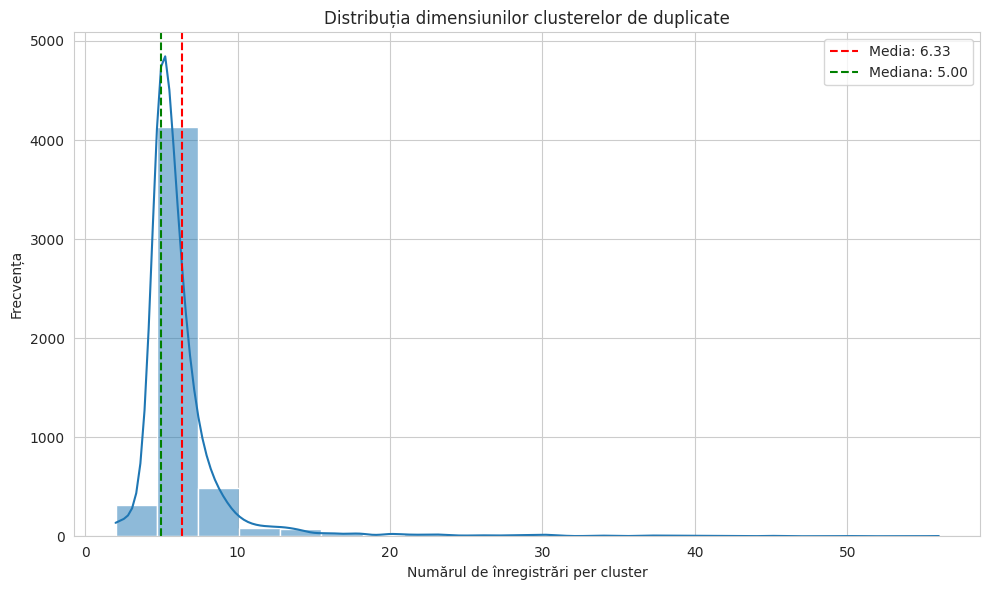

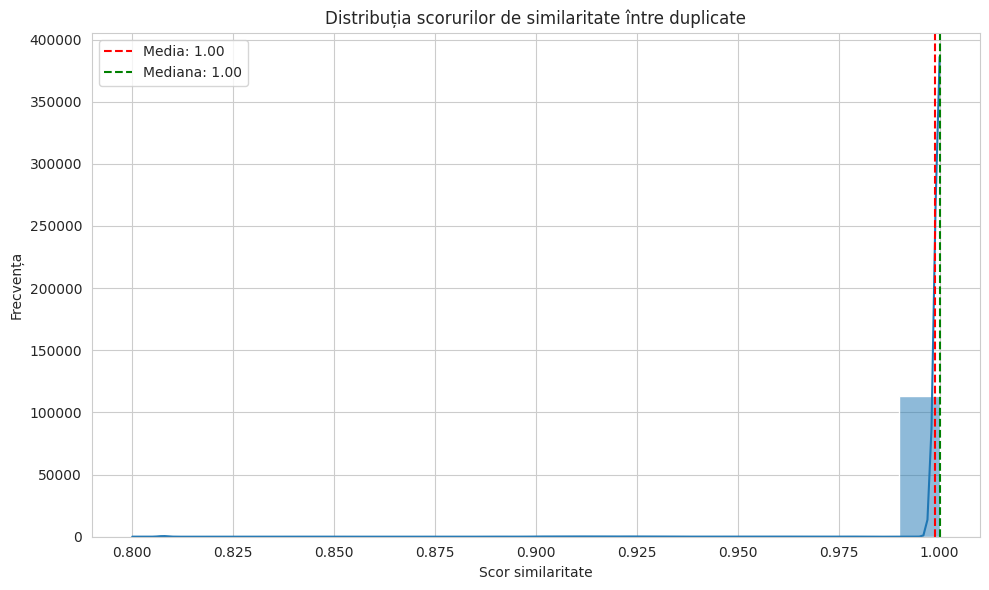

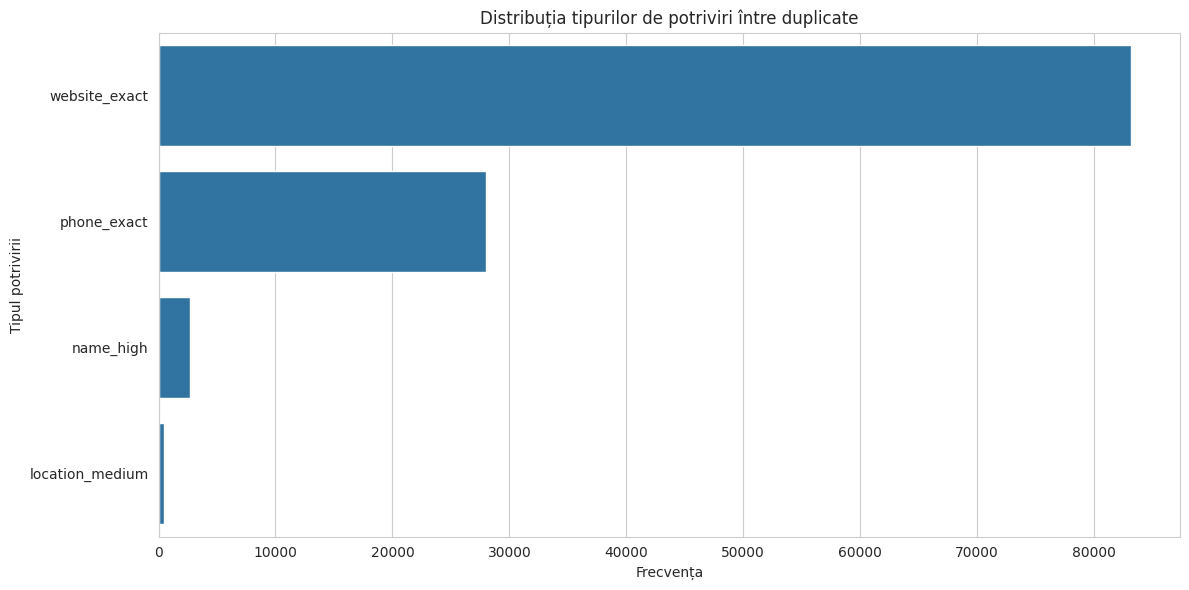

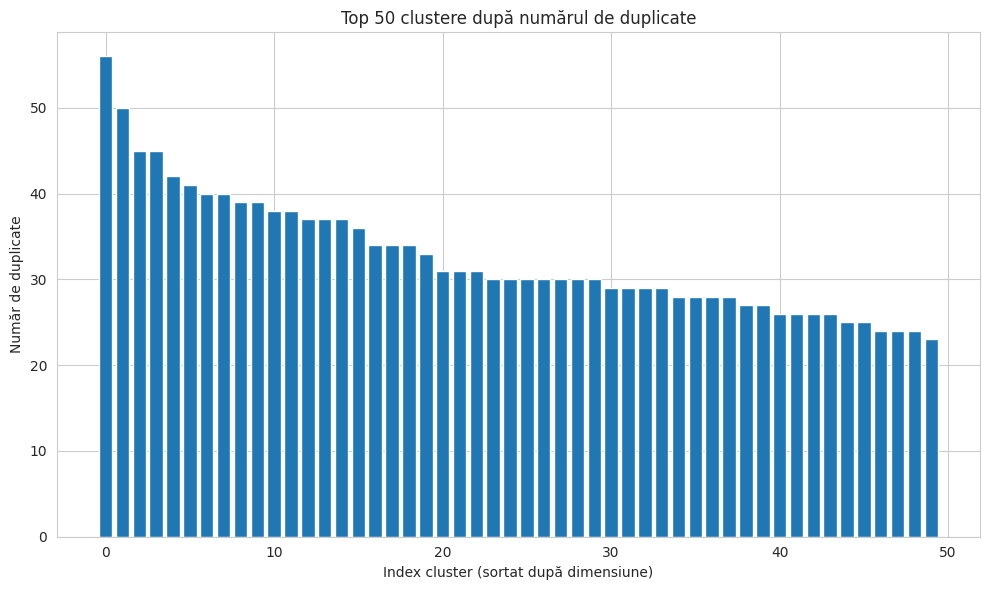

In [28]:
# VIZUALIZARE REZULTATE - HISTOGRAME

print("\nGenerarea histogramelor pentru analiza rezultatelor")

# Importam bibliotecile pentru vizualizare daca nu sunt deja importate
import matplotlib.pyplot as plt
import seaborn as sns

# Setam stilul pentru seaborn
sns.set_style("whitegrid")

# 1. Histograma pentru dimensiunile clusterelor
plt.figure(figsize=(10, 6))
cluster_sizes = deduplicated_df[deduplicated_df['duplicate_count'] > 1]['duplicate_count']
if len(cluster_sizes) > 0:
    sns.histplot(cluster_sizes, bins=20, kde=True)
    plt.title('Distributia dimensiunilor clusterelor de duplicate')
    plt.xlabel('Numarul de inregistrari per cluster')
    plt.ylabel('Frecventa')
    plt.axvline(cluster_sizes.mean(), color='r', linestyle='--', label=f'Media: {cluster_sizes.mean():.2f}')
    plt.axvline(cluster_sizes.median(), color='g', linestyle='--', label=f'Mediana: {cluster_sizes.median():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('cluster_size_histogram.png')
    plt.show()

# 2. Histograma pentru scorurile de similaritate intre inregistrarile duplicate
if edge_info_list:
    plt.figure(figsize=(10, 6))
    similarity_scores = [edge['weight'] for edge in edge_info_list]
    sns.histplot(similarity_scores, bins=20, kde=True)
    plt.title('Distributia scorurilor de similaritate intre duplicate')
    plt.xlabel('Scor similaritate')
    plt.ylabel('Frecventa')
    plt.axvline(np.mean(similarity_scores), color='r', linestyle='--', label=f'Media: {np.mean(similarity_scores):.2f}')
    plt.axvline(np.median(similarity_scores), color='g', linestyle='--', label=f'Mediana: {np.median(similarity_scores):.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('similarity_scores_histogram.png')
    plt.show()

# 3. Histograma pentru tipurile de potriviri
if edge_info_list:
    plt.figure(figsize=(12, 6))
    match_types = [edge['match_type'] for edge in edge_info_list]
    sns.countplot(y=match_types, order=pd.Series(match_types).value_counts().index)
    plt.title('Distributia tipurilor de potriviri intre duplicate')
    plt.xlabel('Frecventa')
    plt.ylabel('Tipul potrivirii')
    plt.tight_layout()
    plt.savefig('match_types_histogram.png')
    plt.show()

# 4. Histograma pentru numarul de duplicate per clustere
if len(clusters) > 0:
    plt.figure(figsize=(10, 6))
    # Cream un DataFrame pentru a usura vizualizarea
    cluster_counts = pd.DataFrame({
        'cluster_id': range(len(clusters)),
        'size': [len(cluster) for cluster in clusters]
    })

    # Sortam clusterele dupa dimensiune pentru o vizualizare mai clara
    cluster_counts = cluster_counts.sort_values('size', ascending=False).reset_index(drop=True)

    # Afisam doar primele N clustere pentru claritate (daca sunt multe)
    top_n = min(50, len(cluster_counts))
    plt.bar(range(top_n), cluster_counts['size'][:top_n])
    plt.title(f'Top {top_n} clustere dupa numarul de duplicate')
    plt.xlabel('Index cluster (sortat dupa dimensiune)')
    plt.ylabel('Numar de duplicate')
    plt.tight_layout()
    plt.savefig('top_clusters_histogram.png')
    plt.show()

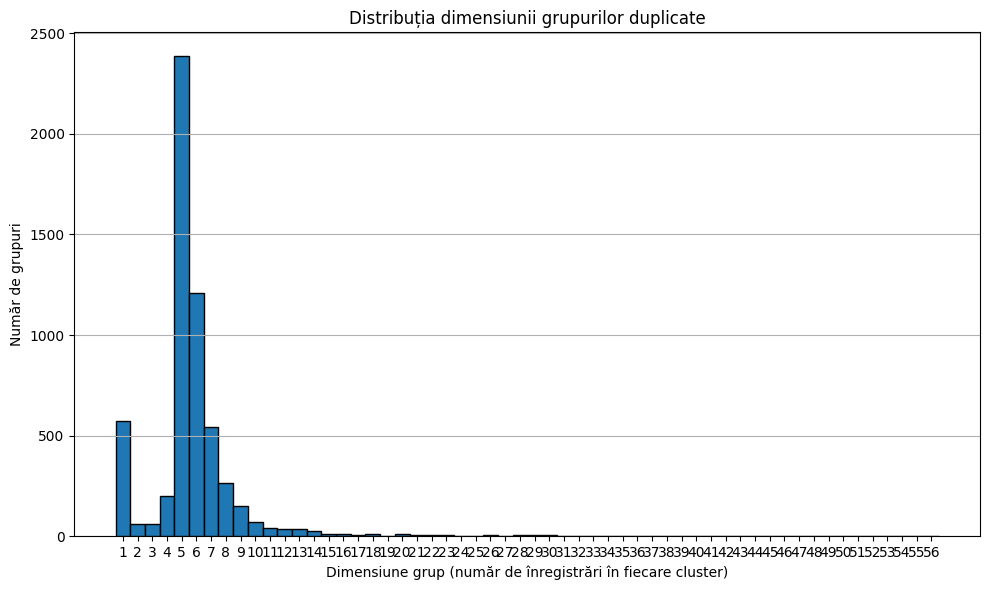

In [31]:
# Hisograma - Distributia dimensiunii grupurilor duplicate
group_sizes = deduplicated_df[deduplicated_df['duplicate_count'] > 0]['duplicate_count']

plt.figure(figsize=(10, 6))
plt.hist(group_sizes, bins=range(1, group_sizes.max() + 2), edgecolor='black', align='left')
plt.title('Distributia dimensiunii grupurilor duplicate')
plt.xlabel('Dimensiune grup (numar de inregistrari in fiecare cluster)')
plt.ylabel('Numar de grupuri')
plt.xticks(range(1, group_sizes.max() + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()
